https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch/?

## EDA

In [161]:
import pandas as pd
import numpy as np

import os
import re

In [162]:
data_path = '../../data/wheat_detection/'

df_train = pd.read_csv(data_path + 'train.csv')
df_sub = pd.read_csv(data_path + 'sample_submission.csv')

In [163]:
df_train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [164]:
df_train = df_train.drop(columns=['width', 'height', 'source'])
df_train.head()

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"


In [165]:
len(df_train['image_id'].unique())

3373

In [166]:
df_train['image_id'].value_counts().max()

116

In [167]:
df_train['image_id'].value_counts().min()

1

In [168]:
aa = df_train['bbox'].iloc[0]
aa

'[834.0, 222.0, 56.0, 36.0]'

In [169]:
bbox_list = df_train['bbox']
x, y, w, h = [], [], [], []
for b in bbox_list:
    bbox = re.findall('[0-9]+[.]?[0-9]*', b)
    x.append(float(bbox[0]))
    y.append(float(bbox[1]))
    w.append(float(bbox[2]))
    h.append(float(bbox[3]))

df_train['x'] = x
df_train['y'] = y
df_train['w'] = w
df_train['h'] = h

df_train.head()

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


In [170]:
image_ids = df_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

df_valid = df_train[df_train['image_id'].isin(valid_ids)]
df_train = df_train[df_train['image_id'].isin(train_ids)]

In [171]:
valid_df.head()

,image_id,bbox,x,y,w,h
122787,bbce58f71,"[430.0, 0.0, 142.0, 75.0]",430.0,0.0,142.0,75.0
122788,bbce58f71,"[255.0, 377.0, 100.0, 69.0]",255.0,377.0,100.0,69.0
122789,bbce58f71,"[788.0, 634.0, 146.0, 77.0]",788.0,634.0,146.0,77.0
122790,bbce58f71,"[344.0, 836.0, 102.0, 110.0]",344.0,836.0,102.0,110.0
122791,bbce58f71,"[217.0, 694.0, 107.0, 85.0]",217.0,694.0,107.0,85.0


In [172]:
train_df.head()

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


## Dataset

In [173]:
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [174]:
class wheatdataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, train=True):
        super().__init__()
        
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.train = train    
        
    def __len__(self):
        
        return self.image_ids.shape[0]
        
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        image = Image.open(self.image_dir + image_id + '.jpg')
        image = np.array(image).astype(np.float32)
        image /= 255.0
        
        if self.transform is not None:
            image = self.transform(image)
        if self.train == False:
            return image, image_id
        
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)

        iscrowd = torch.zeros((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        return image, target, image_id

In [175]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [176]:
train_dir = '../../data/wheat_detection/train/'
test_dir = '../../data/wheat_detection/test/'

transform = transforms.Compose([
    transforms.ToTensor()
])
train_data = wheatdataset(df_train, train_dir, transform, True)
valid_data = wheatdataset(df_valid, train_dir, transform, True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 16, collate_fn=collate_fn)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 8, collate_fn=collate_fn)

In [179]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [189]:
images, targets, image_ids = next(iter(trainloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


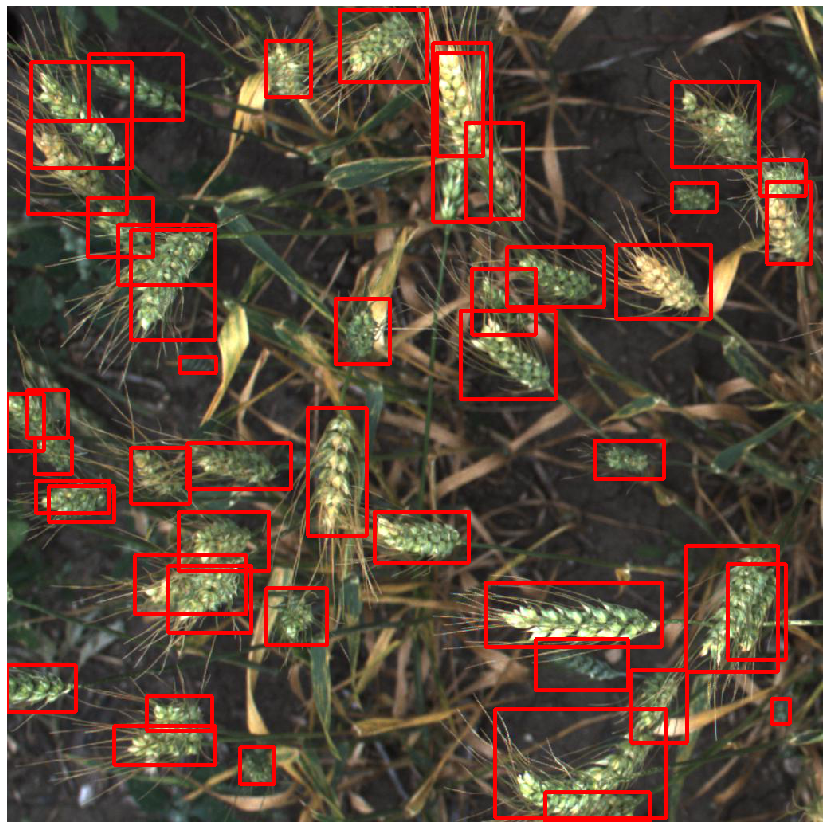

In [198]:
import matplotlib.pyplot as plt
import cv2

boxes = targets[0]['boxes'].numpy()
sample = images[0].permute(1,2,0).numpy()

fig, ax = plt.subplots(1, figsize=(15,15))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)

ax.set_axis_off()
plt.imshow(sample)

## Model

In [200]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [204]:
num_classes = 2 # background & wheat

in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features

1024

In [209]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [210]:
model.load_state_dict(torch.load('../../data/wheat_detection/fasterrcnn_resnet50_fpn_best.pth'))

<All keys matched successfully>

In [213]:
model.eval()

with torch.no_grad():
    model = model.to(device)
    outputs = model(images[0].to(device))

ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([1024, 1024])

In [216]:
images[0].shape

torch.Size([3, 1024, 1024])